# Basics Derivatives

In [1]:
#!conda install -c anaconda graphviz -y

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from graphviz import Digraph

## 1. Derivative of a simple Function

$f(x) = 3x^2 - 4x + 5$

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

### Plotting f(x)

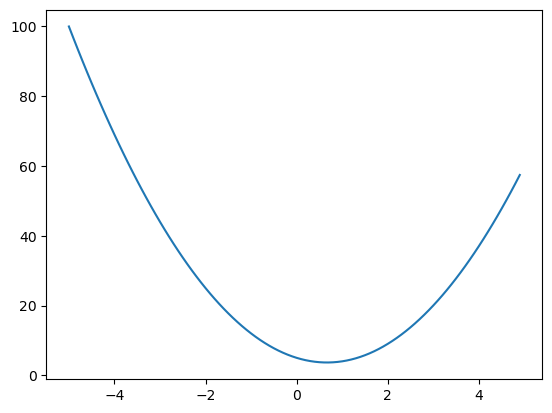

In [4]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)

### Derivative Defination
$
	L = lim_{h->0} \frac{f(a+h) - f(a)}{h}
$

In [5]:
def derivative(f_ah, f_a, h=0.000001):
	return (f_ah - f_a)/h

In [6]:
a = 2/3
h = 0.000001

print(f"Gradient wrt to x: {derivative(f_ah=f(a+h), f_a=f(a), h=h):.4f}")

Gradient wrt to x: 0.0000


## 2. Derivative of complex function

In [7]:
def f2(a, b, c):
    return a*b + c

In [8]:
a = 2.0
b = -3.0
c = 10.0

h = 0.000001


print(f"Gradient wrt to a: {derivative(f_ah=f2(a+h, b, c), f_a=f2(a, b, c), h=h):.4f}")
print(f"Gradient wrt to b: {derivative(f_ah=f2(a, b+h, c), f_a=f2(a, b, c), h=h):.4f}")
print(f"Gradient wrt to c: {derivative(f_ah=f2(a, b, c+h), f_a=f2(a, b, c), h=h):.4f}")

Gradient wrt to a: -3.0000
Gradient wrt to b: 2.0000
Gradient wrt to c: 1.0000


## 3. Python Value objects

### 3.1 Value Object class

In [49]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
        # Gradient
        self._backward = lambda : None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(data=self.data + other.data, _children=(self, other), _op='+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(data=self.data * other.data, _children=(self, other), _op='*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        _tanh = (math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1)
        out = Value(data=_tanh, _children=(self, ), _op='tanh')
        
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        
        return out

    @staticmethod
    def trace(root):
        nodes, edges = set(), set()

        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v._prev:
                    edges.add((child, v))
                    build(child)

        build(root)
        return nodes, edges


    def draw_dot(self):
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

        nodes, edges = self.trace(self)
        for n in nodes:
            uid = str(id(n))
            dot.node(name=uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
            if n._op:
                dot.node(name=uid+n._op, label=n._op)
                dot.edge(uid+n._op, uid)

        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)

        return dot
    
    @staticmethod
    def get_topological_sort(o):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(o)
        return topo
    
    def backward(self):
        topo = self.get_topological_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [15]:
a = Value(2.0)
a

Value(data=2.0)

In [16]:
# Addition

b = Value(-3.0)
a + b

Value(data=-1.0)

In [17]:
# Mulitply

c = Value(10.0)
d = a*b + c
d

Value(data=4.0)

In [18]:
d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

### 3.2 Visualize Value Objects

In [225]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
#    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    dot.node(name=uid, label=f"data {n.data:.4f}", shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [23]:
# Adding labels

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'

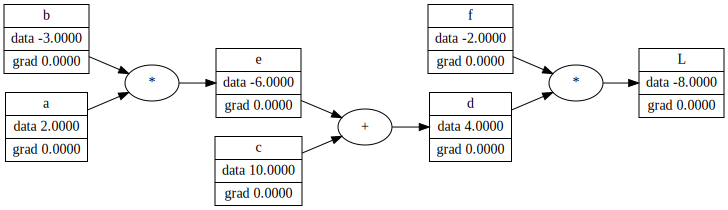

In [24]:
L.draw_dot()

### 3.3 Manually calculating Gradients wrt L

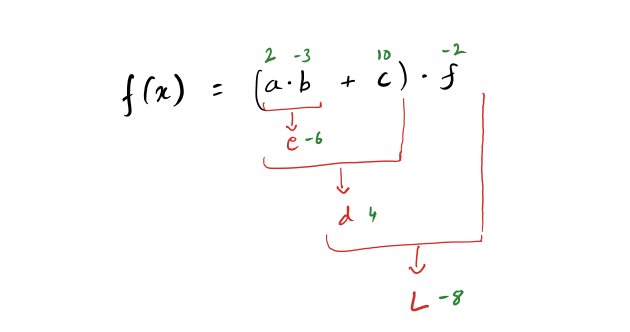

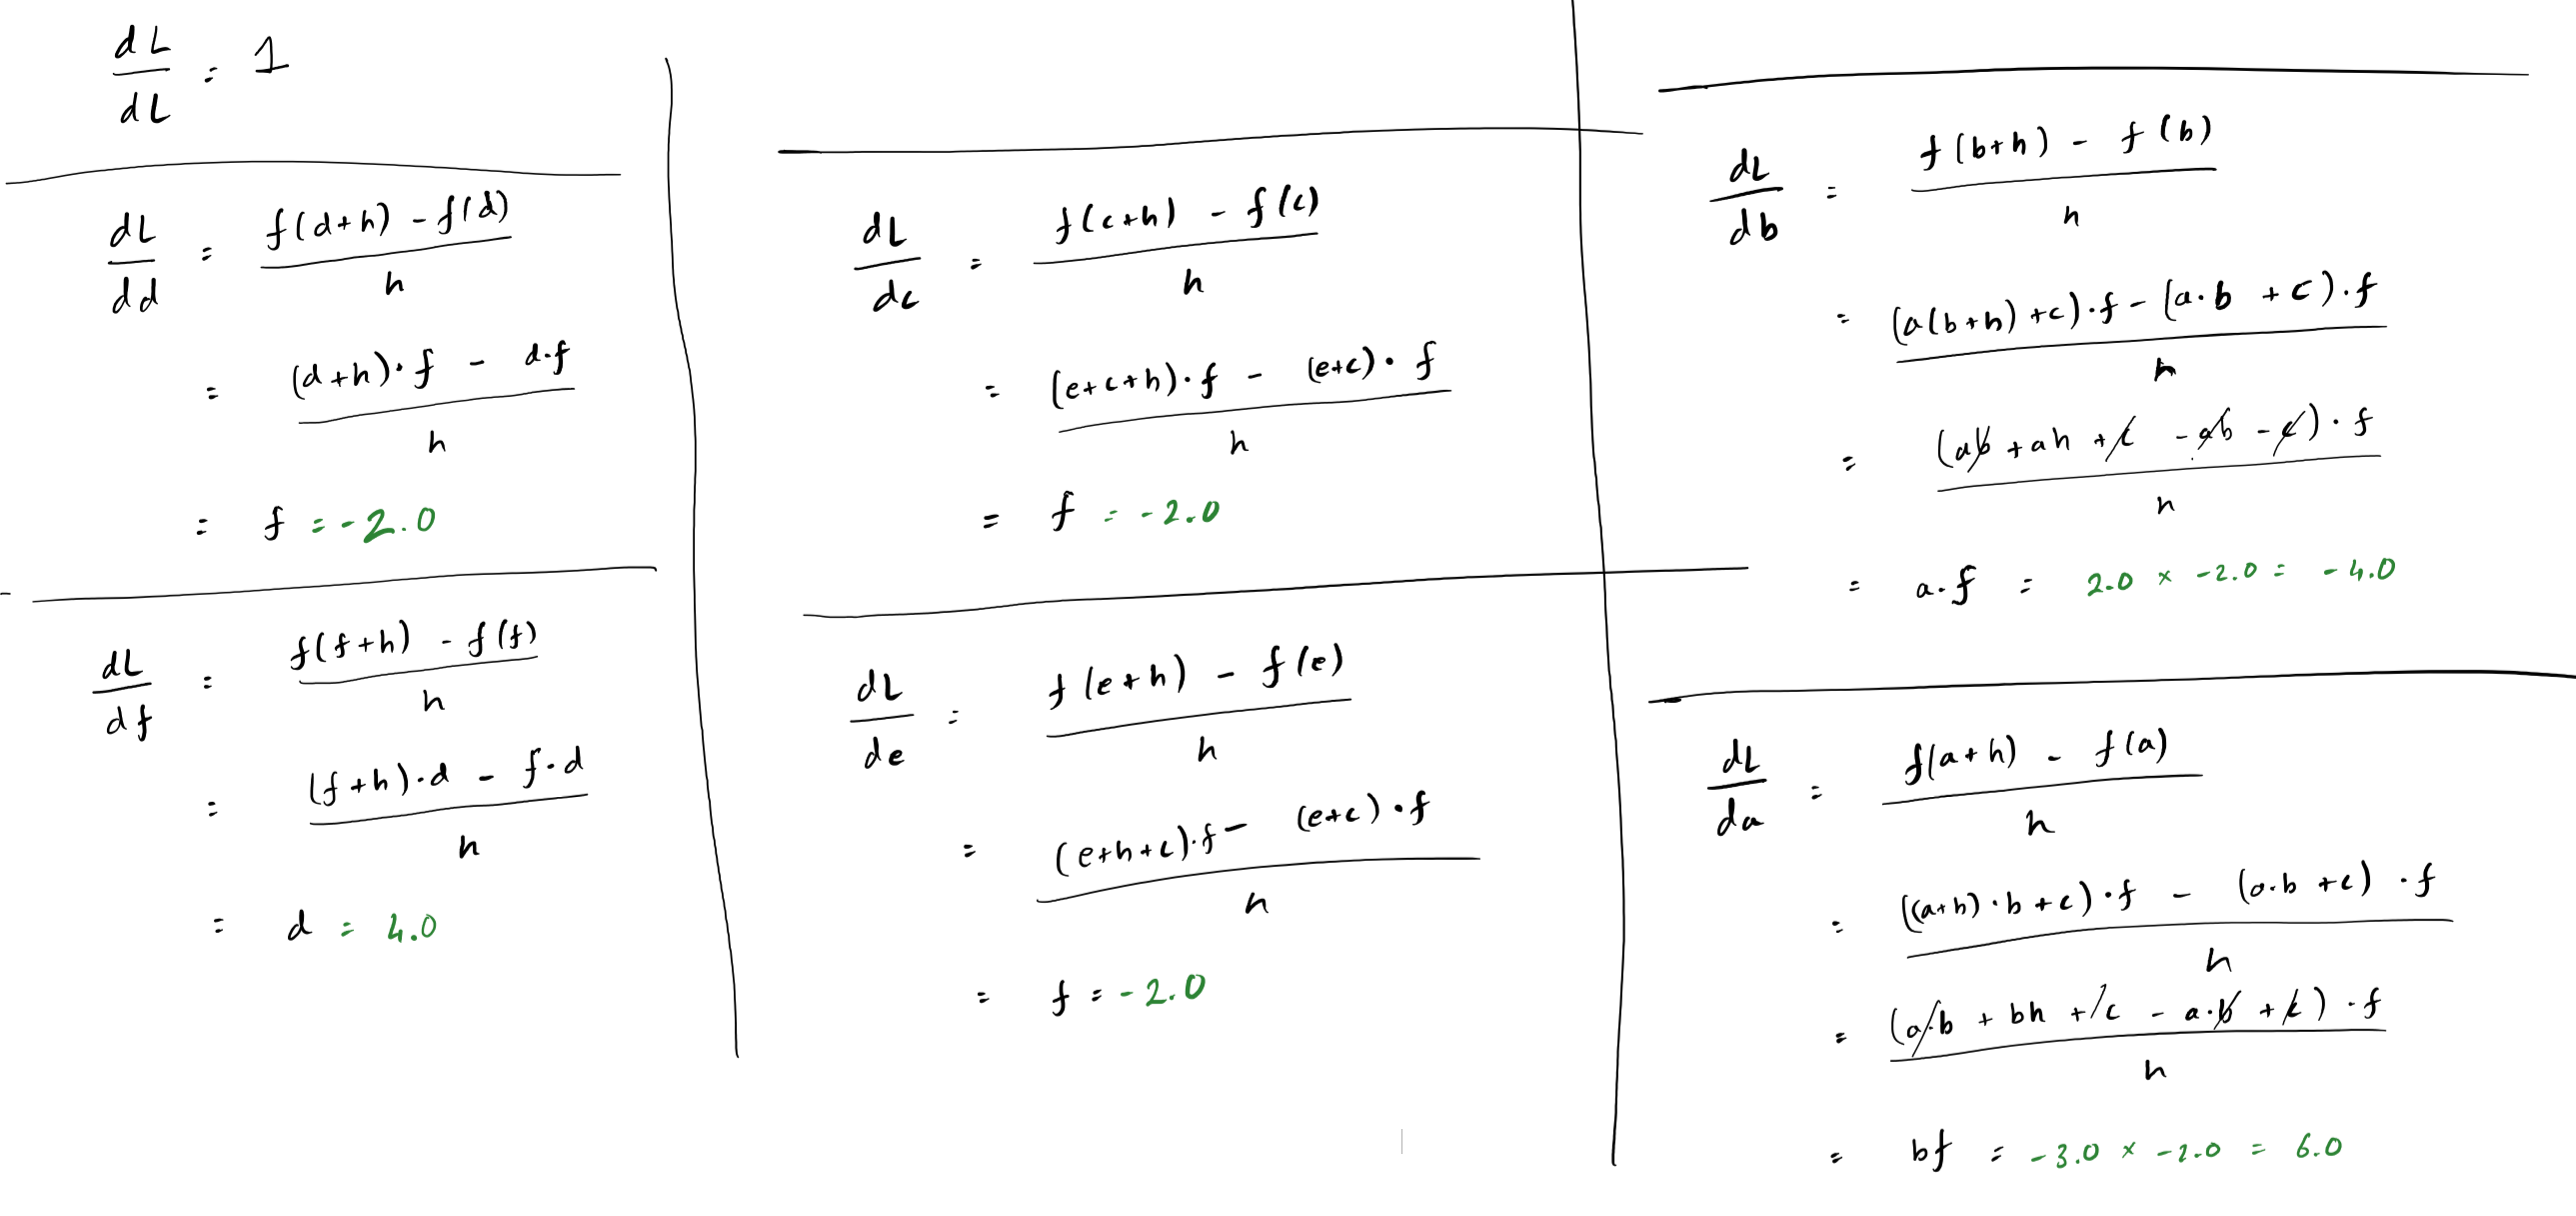

In [25]:
def manual_gradients():
  
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L1 = d*f; L.label='L'
    
    h = 0.00001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    f.data += h
    L2 = d*f; L.label='L'
    
    print(f"Gradient wrt to f: {derivative(f_ah=L2.data, f_a=L1.data, h=h):.4f}")
    
manual_gradients()

Gradient wrt to f: 4.0000


### 3.4 Simple NN, Manual gradient tanH

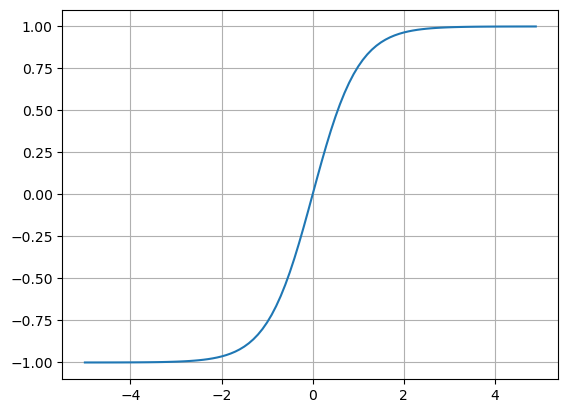

In [26]:
xs = np.arange(-5, 5, 0.1)
ys = np.tanh(xs)
plt.plot(xs, ys)
plt.grid()

In [27]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

# Forward
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label='x1w1 + x2w2'
n = x1w1_x2w2 + b; n.label='n'

# activation
o = n.tanh(); o.label='o'

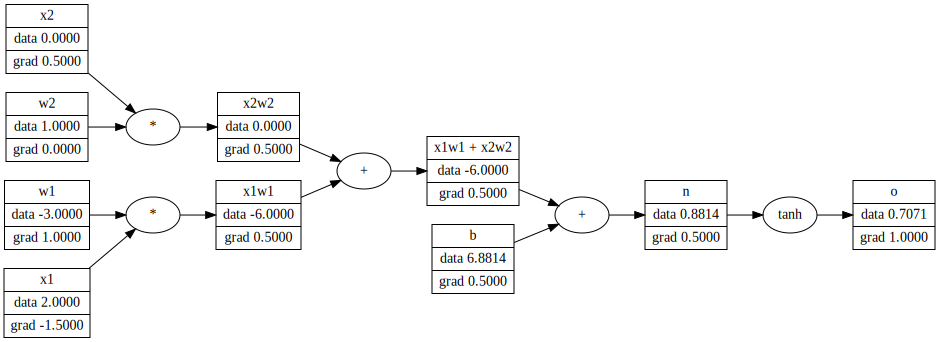

In [35]:
o.draw_dot()

### 3.5 Backward one by one

In [29]:
o.grad=1.0

In [30]:
o._backward()

In [31]:
n._backward()

In [32]:
b._backward()

In [33]:
x1w1_x2w2._backward()

In [34]:
x2w2._backward()
x1w1._backward()

### 3.6 Auto Backward

In [36]:
def get_topological_sort(o):
    topo = []
    visited = set()
    def build_topo(v):
    	if v not in visited:
        	visited.add(v)
        	for child in v._prev:
          		build_topo(child)
        	topo.append(v)
    build_topo(o)
    return topo

In [37]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

# Forward
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label='x1w1 + x2w2'
n = x1w1_x2w2 + b; n.label='n'

# activation
o = n.tanh(); o.label='o'

In [38]:
get_topological_sort(o)

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

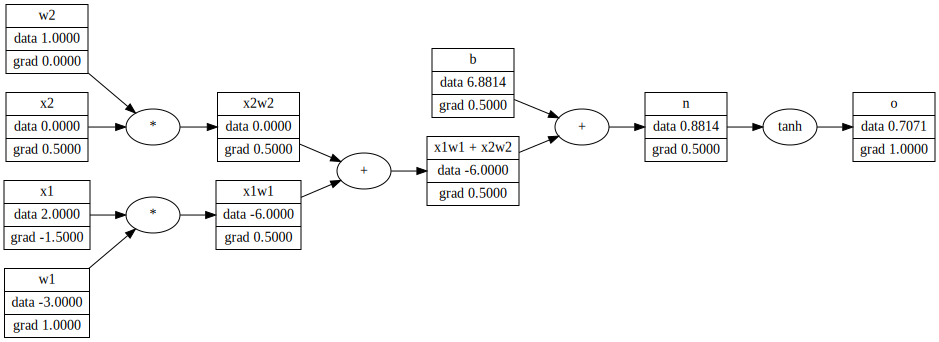

In [41]:
o.draw_dot()

In [40]:
o.backward()

[Value(data=6.881373587019543), Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=2.0), Value(data=-3.0), Value(data=-6.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


#### Bug : same nodes

##### Example 1

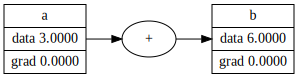

In [42]:
a = Value(3.0, label='a')
b = a + a; b.label='b'

b.draw_dot()

In [43]:
b.backward()

[Value(data=3.0), Value(data=6.0)]


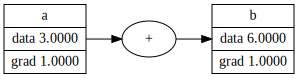

In [44]:
b.draw_dot()

##### Example 2

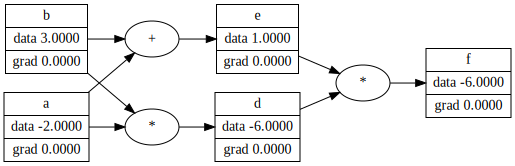

In [45]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.draw_dot()

In [46]:
f.backward()

[Value(data=-2.0), Value(data=3.0), Value(data=1.0), Value(data=-6.0), Value(data=-6.0)]


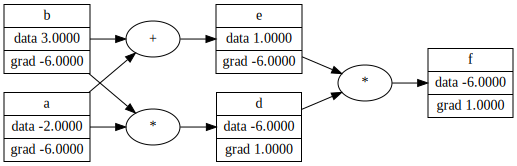

In [48]:

f.draw_dot()

#### Fix : Gradient Accumulation

we sum the gradients

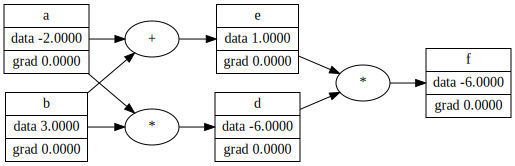

In [50]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.draw_dot()

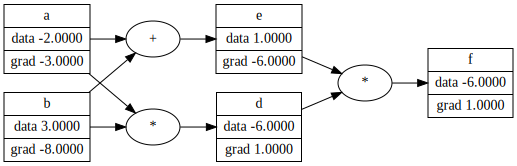

In [51]:
f.backward()
f.draw_dot()

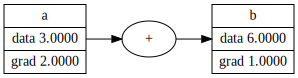

In [52]:
a = Value(3.0, label='a')
b = a + a; b.label='b'

b.backward()
b.draw_dot()